# Data Science Template Notebook

# Imports

In [ ]:
library(tidyverse)
library(GGally)
library(rworldmap)
library(ggrepel)
library(mapproj)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: sp

### Welcome to rworldmap ###

For a short introduction type : 	 vignette('rworldmap')

Loading required package: maps


Attaching package: ‘maps’


The following object is masked from ‘package:purrr’:

    map




# Setup

In [1]:
print("P")

P


In [ ]:
# Plot size
dpi <- 150
width <- 1000 / dpi
height <- 1000 / dpi

options(repr.plot.width = width, repr.plot.height = height)

# Theme for plots
theme_custom <- function(){
    theme_minimal() %+replace%
    theme(aspect.ratio = height / width,
    plot.title = element_text(size = 24),
    axis.title = element_text(size = 20),
    axis.text = element_text(size = 16),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14))
}

# Theme for time series plots
theme_custom_ts <- function(){
    theme_minimal() %+replace%
    theme(aspect.ratio = 12/24,
          plot.margin = grid::unit(c(1,1,1,1), "mm"),
          text = element_text(size = 18))
}

# Theme for tile plots
theme_custom_tiles <- function(){
    theme_minimal() %+replace%    
    theme(text = element_text(size = 18),
          axis.text.x = element_text(angle = 90, 
                                     hjust = 0.95, 
                                     vjust = 0.25),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          plot.background = element_blank(),
          panel.border = element_blank(), 
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank()        
    )
    
}

# Goal

The goal is to visualize the `Global Terrorism Database`.

# Data Sources

The data comes from:
[Global Terrorism Database](http://start.umd.edu/gtd/)

And along with it comes detailed documentation:
[Global Terrorism Database Codebook](http://start.umd.edu/gtd/downloads/Codebook.pdf)

The set itself was downloaded from:
[Global Terrorism Dataset on kaggle](https://www.kaggle.com/START-UMD/gtd)

# Data Loading

In [ ]:
df <- read.csv("./data/globalterrorismdb_0718dist.csv")

In [ ]:
dim(df)

[1] 181691    135

# Data Cleaning

In [ ]:
## Preview columns

In [ ]:
# colnames(df)

## Subetting

In [ ]:
data <- df %>%
    dplyr::select(
        
        # Time
        iyear,           # Year
        imonth,          # Month
        iday,            # Day
             
        # Geospatial
        latitude,        # Geo coordinate
        longitude,       # Geo coordinate
             
        # Numerical
        nperps,          # Number of perpetrators
        nkill,           # Death toll
        nwound,          # No of casualties
        nkillter,        # Death toll - terrorist only
        propextent,      # Amount of damage done                  
        ransomamt,       # Any ransom demanded ?         
             
        # Binary
        doubtterr,       # Was an act of terror ?
        vicinity,        # Did event occur in city ?
        ishostkid,       # Hostages
        extended,        # Duration above 24hrs ?
        
        # Categorical
        city,            # City        
        country,         # Country id
        region,          # Region id        
        country_txt,     # Desc country
        region_txt,      # Desc region  
        attacktype1_txt, # Desc attack type
        weaptype1_txt,   # Desc weapon type
        targtype1_txt,   # Desc target type

            
        # Text
        #  summary,      # Motive text variable
        gname            # Name of organization
    )

## Renaming

In [ ]:
data <- data %>%
    dplyr::rename(year = iyear,
                  month = imonth,
                  day = iday,
                  damage = propextent,
                  lat = latitude,
                  long = longitude) %>%
    dplyr::mutate(country = country_txt,
                  region = region_txt,
                  attack = attacktype1_txt,
                  weapon = weaptype1_txt,
                  target = targtype1_txt) %>%
    dplyr::select(-country_txt, 
                  -region_txt, 
                  -attacktype1_txt, 
                  -weaptype1_txt, 
                  -targtype1_txt)

In [ ]:
data <- data %>%
    dplyr::mutate(attack = as.character(attack)) %>%
    dplyr::mutate(attack = ifelse(attack == 'Facility/Infrastructure Attack', 'Infrastructure Attack', attack),
                  attack = ifelse(attack == 'Bombing/Explosion', 'Explosion', attack),
                  attack = ifelse(attack == 'Hostage Taking (Barricade Incident)', 'Hostage (Barricade)', attack),
                  attack = ifelse(attack == 'Hostage Taking (Kidnapping)', 'Hostage (Kidnapping)', attack)) %>%
    dplyr::mutate(attack = as.factor(attack))

In [ ]:
data <- data %>%
    dplyr::mutate(weapon = as.character(weapon)) %>%
    dplyr::mutate(weapon = ifelse(weapon == 'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'Vehicle', weapon)) %>%
    dplyr::mutate(weapon = as.factor(weapon))

In [ ]:
data <- data %>%
    dplyr::mutate(target = as.character(target)) %>%
    dplyr::mutate(target = ifelse(target == 'Government (General)', 'Government', target)) %>%
    dplyr::mutate(target = ifelse(target == 'Private Citizens & Property', 'Private', target)) %>%
    dplyr::mutate(target = as.factor(target))

In [ ]:
data <- data %>%
    dplyr::mutate(country = as.character(country)) %>%
    dplyr::mutate(country = ifelse(country == 'Democratic Republic of the Congo', 'Congo', country)) %>%
    dplyr::mutate(country = as.factor(country))

In [ ]:
data <- data %>%
    dplyr::mutate(gname = as.character(gname)) %>%
    dplyr::mutate(gname = ifelse(gname == 'Islamic State of Iraq and the Levant (ISIL)', 'ISIL', gname),
                  gname = ifelse(gname == 'Al-Qaida in Iraq', 'Al-Qaida', gname),
                  gname = ifelse(gname == 'Al-Nusrah Front', 'Al-Nusrah', gname),                                    
                  gname = ifelse(gname == 'Fulani extremists', 'Fulani', gname),                  
                  gname = ifelse(gname == 'Houthi extremists (Ansar Allah)', 'Ansar Allah', gname),                                    
                  gname = ifelse(gname == 'Communist Party of India - Maoist (CPI-Maoist)', 'CPI - Maoist', gname),                                    
                  gname = ifelse(gname == 'Tehrik-i-Taliban Pakistan (TTP)', 'TTP', gname)) %>%
    dplyr::mutate(gname = as.factor(gname))

In [ ]:
dim(data)

[1] 181691     22

## Filtering

In [ ]:
data <- data %>%
    dplyr::filter(2007 <= year & 
                  year <= 2017 &
                  doubtterr == 0)

In [ ]:
dim(data)

[1] 83606    22

## Missing values

In [ ]:
data <- data %>%
    dplyr::mutate(doubtterr = ifelse(doubtterr < 0, 0, doubtterr),
                  vicinity = ifelse(vicinity < 0, 0, vicinity), 
                  extended = ifelse(extended < 0, 0, extended),
                  ishostkid = ifelse(ishostkid < 0, 0, ishostkid))

In [ ]:
data <- data %>%
    dplyr::mutate(nperps = ifelse(nperps <= 0, 1, nperps),
                  nkill = ifelse(nkill < 0, 0, nkill),
                  nwound = ifelse(nwound < 0, 0, nkill),
                  nkillter = ifelse(nkillter < 0, 0, nkillter),
                  ransomamt = ifelse(ransomamt < 0, 0, ransomamt),
                  damage = ifelse(damage < 0, 0, damage))

In [ ]:
data <- data %>% 
    tidyr::replace_na(list('doubtterr' = 0,
                           'vicinity' = 0,
                           'extended' = 0,
                           'ishostkid' = 0,
                           'nperps' = 1, 
                           'nkill' = 0, 
                           'nwound' = 0, 
                           'nkillter' = 0, 
                           'ransomamt' = 0, 
                           'damage' = 0))

## Types & formats

In [ ]:
data <- data %>%
    dplyr::mutate(nwound = as.integer(nwound),
                  doubtterr = as.logical(doubtterr), 
                  vicinity = as.logical(vicinity),
                  extended = as.logical(extended),
                  ishostkid = as.logical(ishostkid))

In [ ]:
glimpse(data)

Rows: 83,606
Columns: 22
$ year      <int> 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007,…
$ month     <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ day       <int> 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 7,…
$ lat       <dbl> 31.356581, 13.727896, 34.467964, 29.034412, 34.346722, 4.13…
$ long      <dbl> 34.32656, 100.52412, 70.49149, 69.15866, 62.19732, 32.29349…
$ nperps    <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ nkill     <dbl> 0, 3, 0, 0, 2, 13, 0, 2, 14, 0, 13, 0, 5, 48, 3, 1, 1, 12, …
$ nwound    <int> 0, 3, 0, 0, 2, 13, 0, 2, 0, 0, 13, 0, 5, 48, 3, 1, 1, 12, 1…
$ nkillter  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0…
$ damage    <dbl> 0, 4, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 0, 0, 0, 0, 3, 0, 0,…
$ ransomamt <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ doubtterr <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FAL…
$ vicinity  <lgl> FALSE, FA

## Derived measures

In [ ]:
data <- data %>%
    dplyr::mutate(month = ifelse(month == 0, 6, month),
                  day = ifelse(day == 0, 15, day),
                  date = lubridate::make_date(year, month, day)) %>%
    dplyr::filter(!is.na(date))

In [ ]:
dim(data)

[1] 83606    23

## Encoding

In [ ]:
data <- data %>%
    dplyr::mutate(damage = ifelse(damage == 0, "Unknown", damage),
                  damage = ifelse(damage == 4, "Unknown", damage),
                  damage = ifelse(damage == 3, "Low", damage),
                  damage = ifelse(damage == 2, "Medium", damage),
                  damage = ifelse(damage == 1, "High", damage),
                  damage = as.factor(damage))

# Data Exploration

## Dates & timestamps

In [ ]:
min(data$date)

[1] "2007-01-01"

In [ ]:
max(data$date)

[1] "2017-12-31"

## Categorical variables

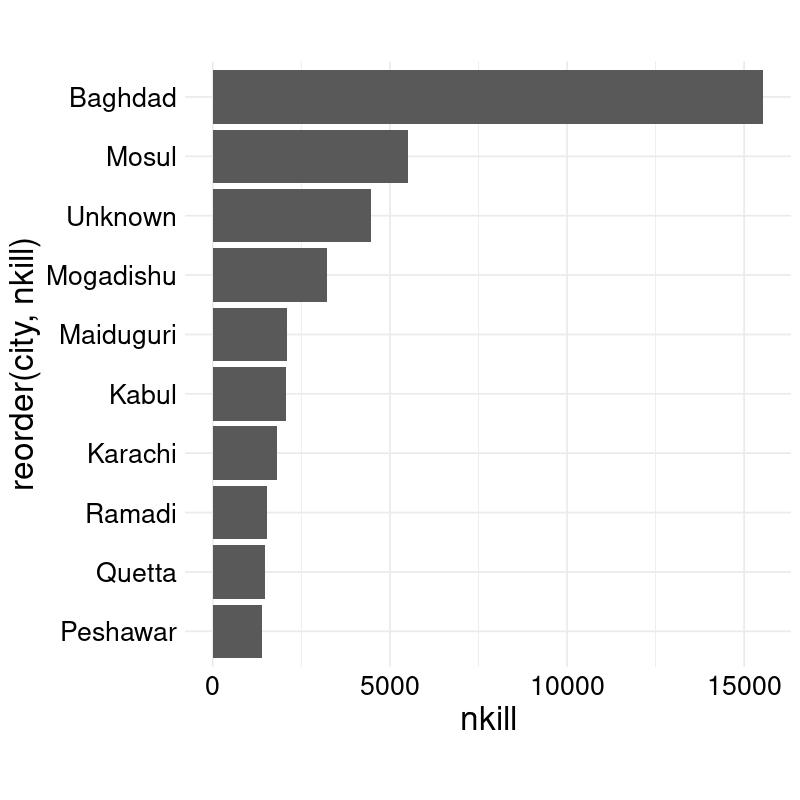

In [ ]:
by_city <- data %>%
    dplyr::filter(city != '') %>%
    dplyr::group_by(city) %>%
    dplyr::summarise(nkill = sum(nkill), .groups = 'drop') %>%
    dplyr::arrange(-nkill) %>%
    dplyr::top_n(nkill, n = 10)
  
ggplot(data = by_city, aes(x = reorder(city, nkill), y = nkill)) + 
    geom_bar(stat = 'identity') +
    coord_flip() +
    theme_custom() 

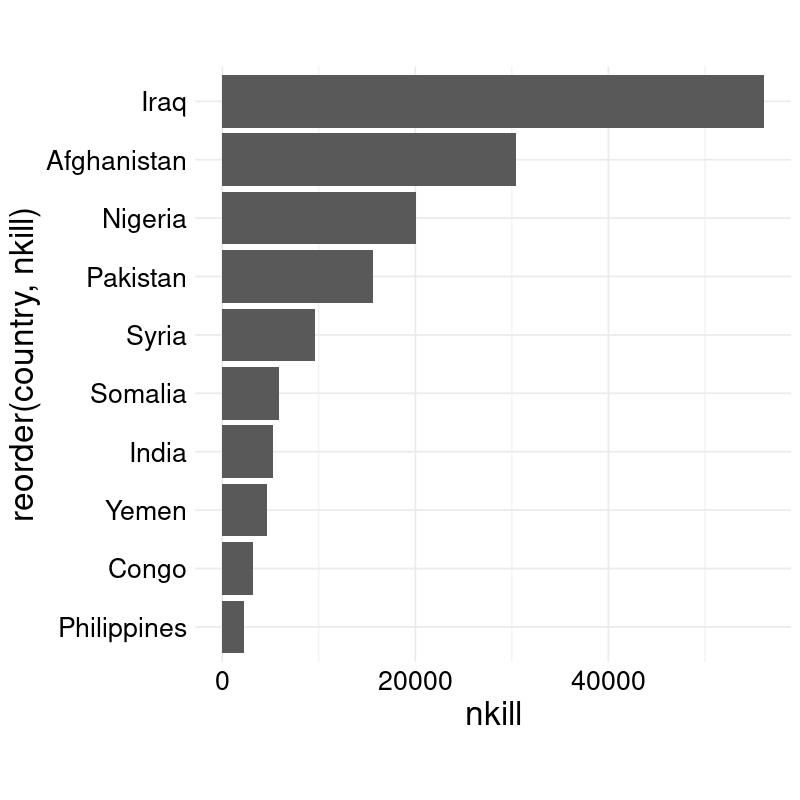

In [ ]:
by_country <- data %>%
    dplyr::group_by(country) %>%
    dplyr::summarise(nkill = sum(nkill), .groups = 'drop') %>%
    dplyr::arrange(-nkill) %>%
    dplyr::top_n(nkill, n = 10)

ggplot(data = by_country, aes(x = reorder(country, nkill), y = nkill)) + 
    geom_bar(stat = 'identity') +
    coord_flip() +
    theme_custom() 

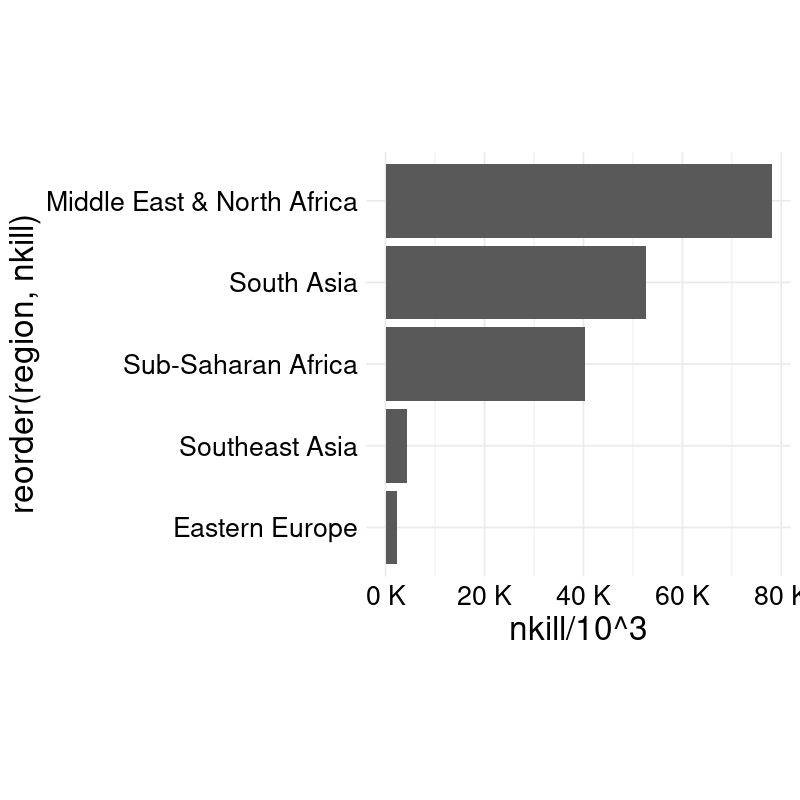

In [ ]:
by_region <- data %>%
    dplyr::group_by(region) %>%
    dplyr::summarise(nkill = sum(nkill), .groups='drop') %>%
    dplyr::arrange(-nkill) %>%
    dplyr::top_n(nkill, n = 5)
    
ggplot(data = by_region, aes(x = reorder(region, nkill), y = nkill / 10 ^ 3)) + 
    geom_bar(stat = 'identity') +
    coord_flip() +
    scale_y_continuous(labels = scales::unit_format(unit = "K")) +
    theme_custom() 

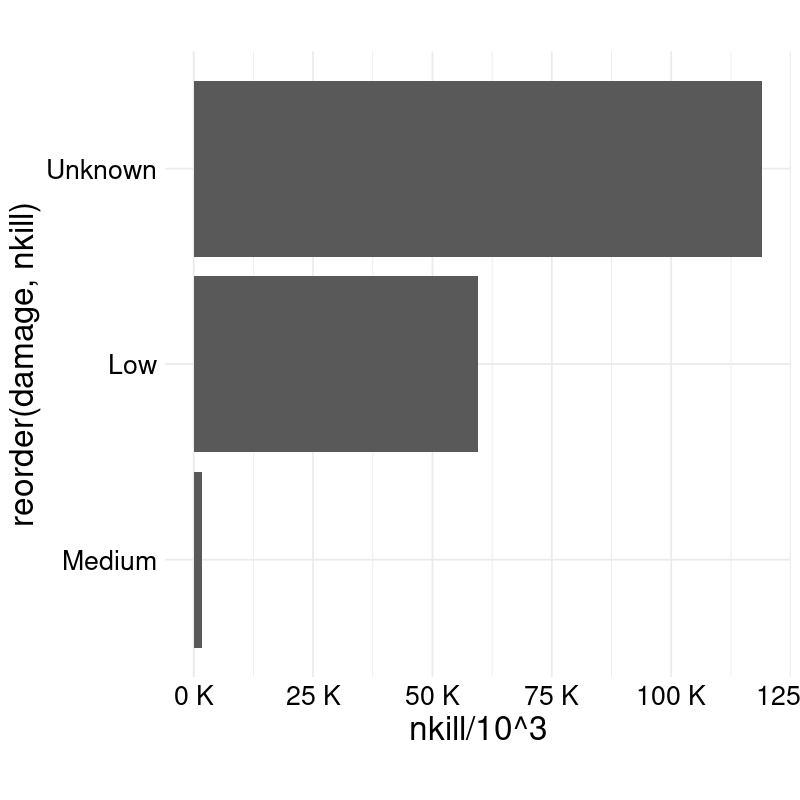

In [ ]:
by_damage <- data %>%
    dplyr::group_by(damage) %>%
    dplyr::summarise(nkill = sum(nkill), .groups = 'drop') %>%
    dplyr::arrange(-nkill)

ggplot(data = by_damage, aes(x = reorder(damage, nkill), y = nkill / 10 ** 3)) +
    geom_bar(stat = 'identity') +
    scale_y_continuous(labels = scales::unit_format(unit = "K")) +
    coord_flip() +
    theme_custom() 

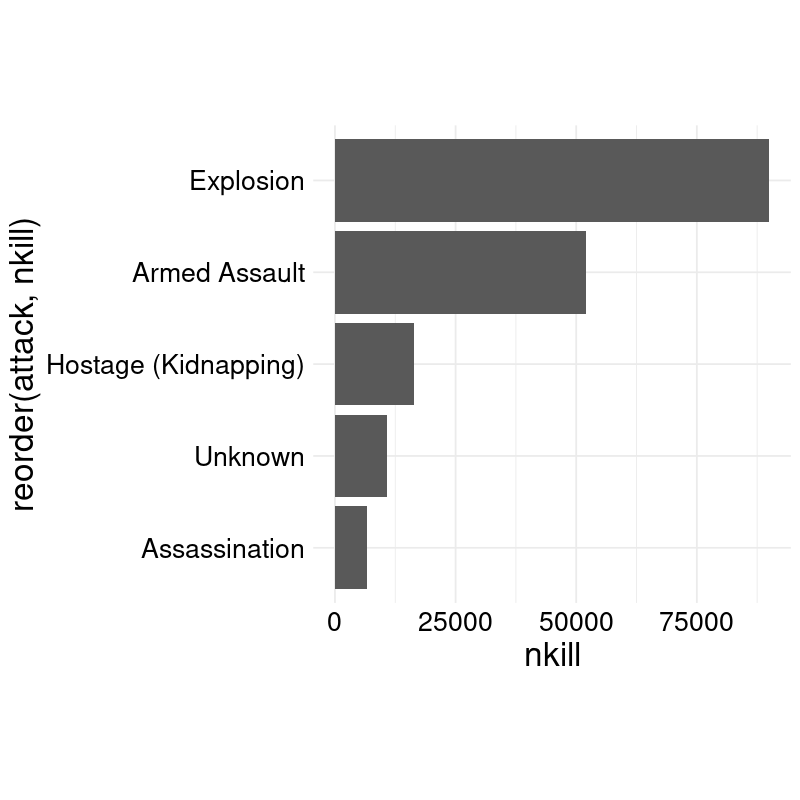

In [ ]:
by_attack <- data %>%
    dplyr::group_by(attack) %>%
    dplyr::summarise(nkill = sum(nkill), .groups = 'drop') %>%
    dplyr::arrange(-nkill) %>%
    dplyr::top_n(nkill, n = 5)
  
ggplot(data = by_attack, aes(x = reorder(attack, nkill), y = nkill)) +
    geom_bar(stat = 'identity') +
    coord_flip() +
    theme_custom() 

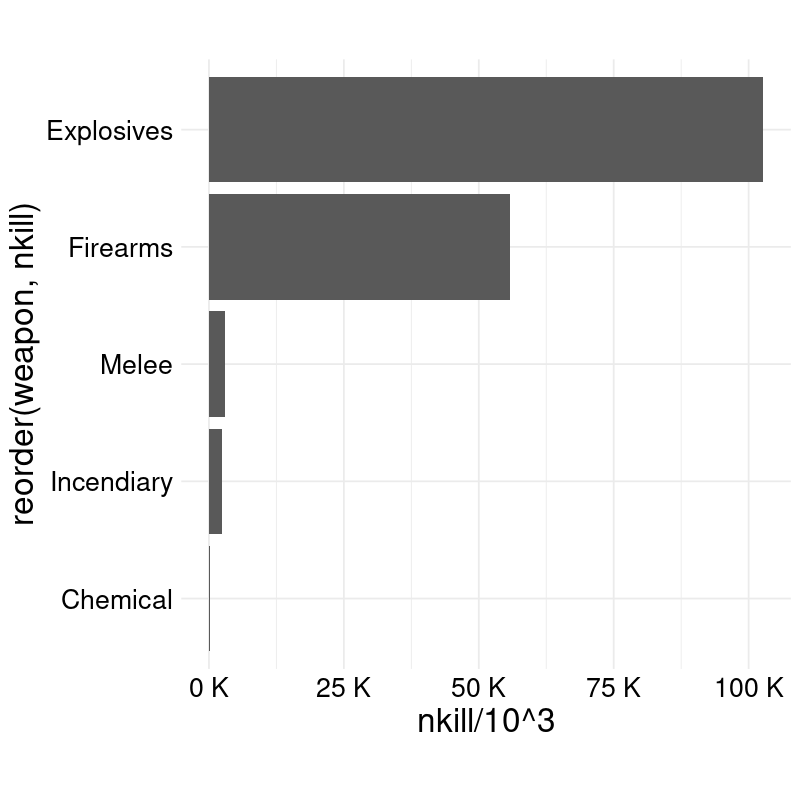

In [ ]:
by_weapon <- data %>%
    dplyr::select(weapon, nkill) %>%
    dplyr::filter(weapon != 'Unknown' & weapon != 'Other') %>%
    dplyr::group_by(weapon) %>%
    dplyr::summarize(nkill = sum(nkill), .groups = 'drop') %>%
    dplyr::arrange(-nkill) %>%
    dplyr::top_n(nkill, n = 5)

ggplot(data = by_weapon, aes(x = reorder(weapon, nkill), y = nkill / 10 ^ 3)) +
    geom_bar(stat = 'identity') +
    scale_y_continuous(labels = scales::unit_format(unit = "K")) +
    coord_flip() +
    theme_custom() 

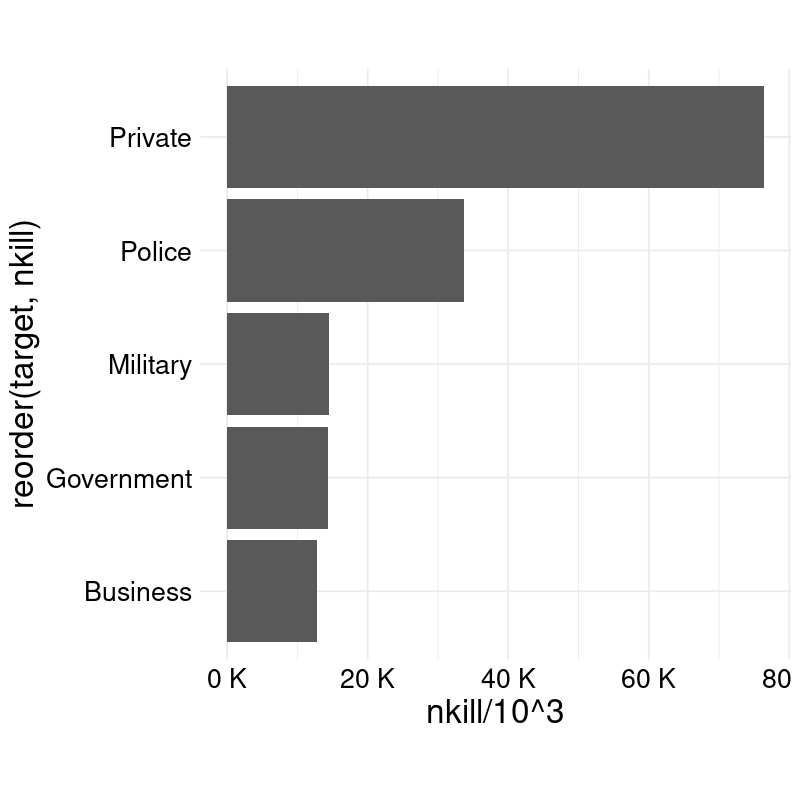

In [ ]:
by_target <- data %>%
    dplyr::select(target, nkill) %>%
    dplyr::filter(target != 'Unknown') %>%
    dplyr::group_by(target) %>%
    dplyr::summarize(nkill = sum(nkill), .groups = 'drop') %>%
    dplyr::arrange(-nkill) %>%
    dplyr::top_n(nkill, n = 5)

ggplot(data = by_target, aes(x = reorder(target, nkill), y = nkill / 10 ^ 3)) +
    geom_bar(stat = 'identity') +
    scale_y_continuous(labels = scales::unit_format(unit = "K")) +
    coord_flip() +
    theme_custom() 

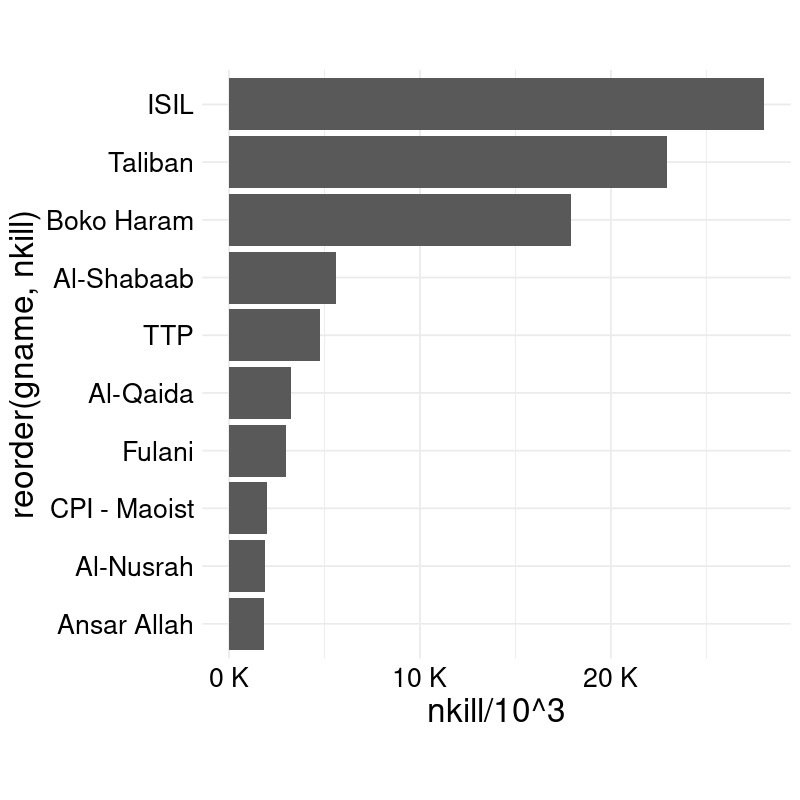

In [ ]:
by_gname <- data %>%
    dplyr::select(gname, nkill) %>%
    dplyr::group_by(gname) %>%
    dplyr::summarize(nkill = sum(nkill), .groups = 'drop') %>%
    dplyr::filter(nkill > 0 & gname != 'Unknown') %>%
    dplyr::arrange(-nkill) %>%
    dplyr::top_n(nkill, n = 10)

ggplot(data = by_gname, aes(x = reorder(gname, nkill), y = nkill / 10 ^ 3)) +
    geom_bar(stat = 'identity') +
    scale_y_continuous(labels = scales::unit_format(unit = "K")) +
    coord_flip() +
    theme_custom() 

In [ ]:
most_active <- as.character(by_gname$gname)[1:5]

group_targets <- data %>%
    dplyr::filter(gname %in% most_active) %>%
    dplyr::group_by(gname, country, target) %>%
    dplyr::summarize(nkill = sum(nkill), .groups = "drop") %>%
    dplyr::group_by(gname) %>%
    dplyr::arrange(dplyr::desc(nkill)) %>%
    dplyr::summarize(nkill = first(nkill),
                     target = first(target),
                     .groups = "drop")

group_targets

gname,nkill,target
<fct>,<dbl>,<fct>
Al-Shabaab,1138,Government
Boko Haram,10242,Private
ISIL,12507,Private
Taliban,10721,Police
TTP,1543,Private


## Numerical variables

### Descriptive statistics

In [ ]:
numerical <- c("nperps",
               "nkill",
               "nwound",
               "nkillter",
               "ransomamt")

In [ ]:
summary(dplyr::select_at(data, numerical))

     nperps            nkill             nwound           nkillter       
 Min.   :   1.00   Min.   :  0.000   Min.   :  0.000   Min.   :  0.0000  
 1st Qu.:   1.00   1st Qu.:  0.000   1st Qu.:  0.000   1st Qu.:  0.0000  
 Median :   1.00   Median :  0.000   Median :  0.000   Median :  0.0000  
 Mean   :   3.14   Mean   :  2.157   Mean   :  1.804   Mean   :  0.3771  
 3rd Qu.:   1.00   3rd Qu.:  2.000   3rd Qu.:  1.000   3rd Qu.:  0.0000  
 Max.   :5000.00   Max.   :953.000   Max.   :670.000   Max.   :301.0000  
   ransomamt        
 Min.   :        0  
 1st Qu.:        0  
 Median :        0  
 Mean   :    17457  
 3rd Qu.:        0  
 Max.   :200000000  

### Plots over time

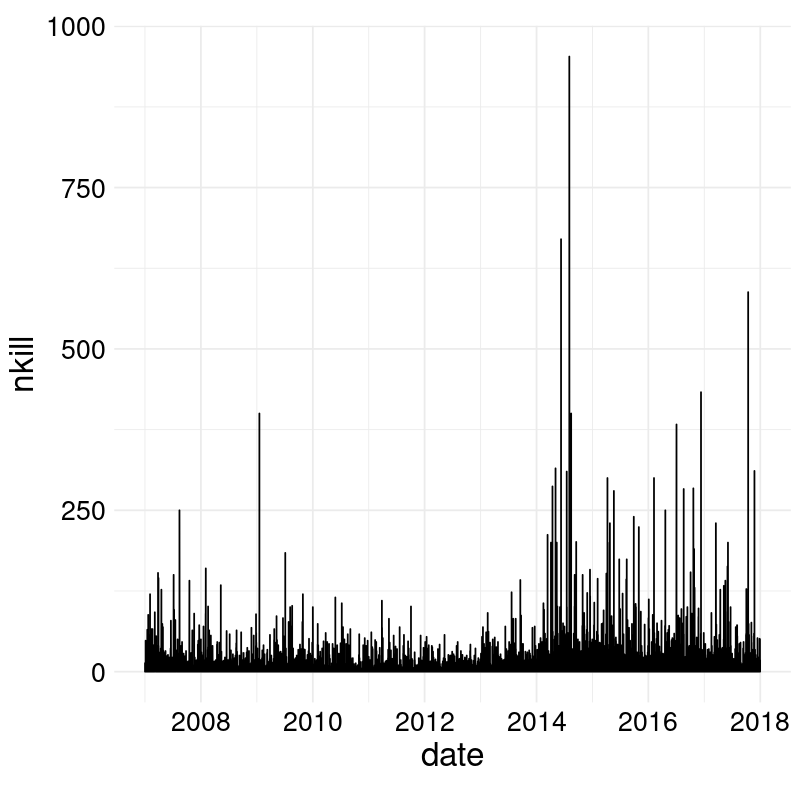

In [ ]:
nkill_daily <- data %>%
    dplyr::select(date, nkill) %>% 
    tidyr::fill(nkill, 0) %>%
    dplyr::mutate(nkill = ifelse(nkill < 0, 0, nkill))

ggplot(data = nkill_daily, aes(x = date, y = nkill)) +
    geom_line() + 
    theme_custom()

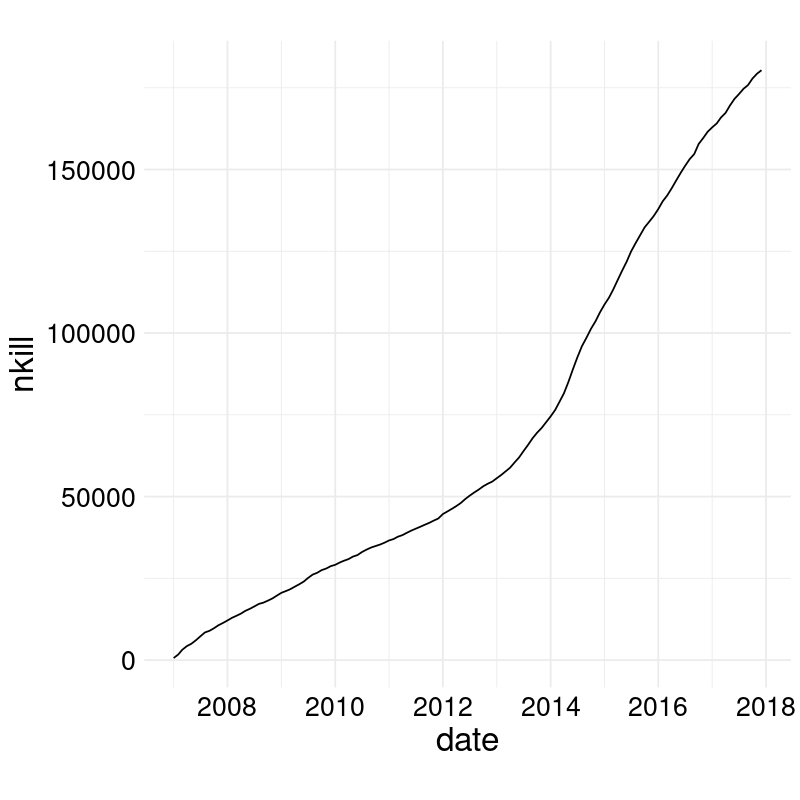

In [ ]:
nkill_monthly <- data %>%
    dplyr::select(year, month, nkill) %>% 
    tidyr::fill(nkill, 0) %>%
    dplyr::mutate(nkill = ifelse(nkill < 0, 0, nkill)) %>%
    dplyr::group_by(year, month) %>%
    dplyr::summarise(nkill = sum(nkill), .groups = 'drop') %>%
    dplyr::mutate(date = lubridate::make_date(year, month, 1),
                  nkill = base::cumsum(nkill)) %>%
    dplyr::select(-year, -month)

ggplot(data = nkill_monthly, aes(x = date, y = nkill)) +
    geom_line() + 
    theme_custom()

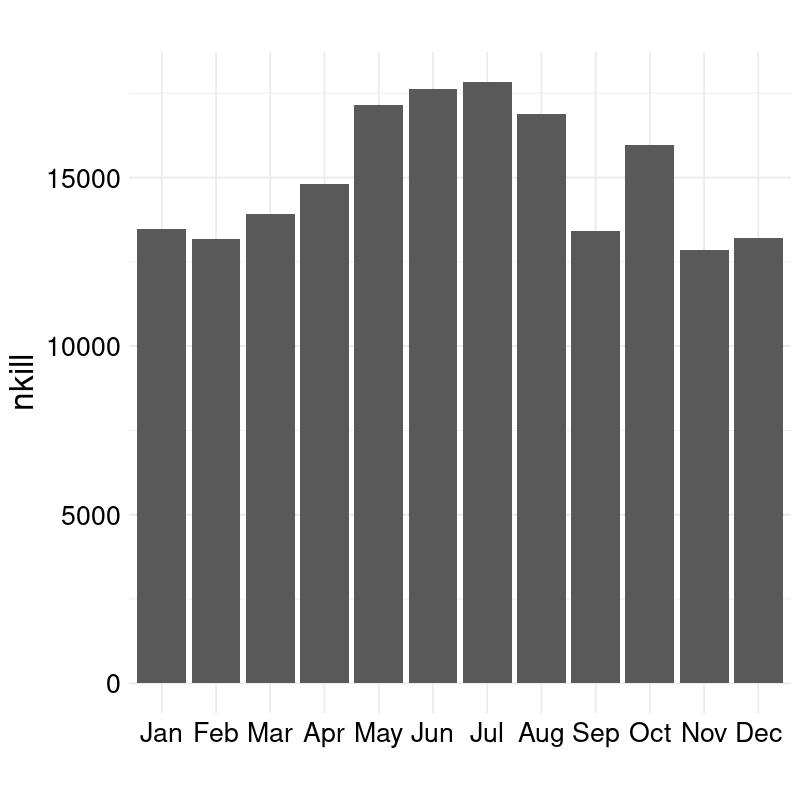

In [ ]:
by_month <- data %>%
    dplyr::select(month, nkill) %>%
    dplyr::group_by(month) %>%
    dplyr::summarize(nkill = sum(nkill), .groups = 'drop') %>%
    dplyr::mutate(monthname = month.abb[month])

ggplot(by_month, aes(x = reorder(monthname, month), y = nkill)) +
    geom_bar(stat = 'identity') +
    theme_custom() + 
    theme(axis.title.x = element_blank())

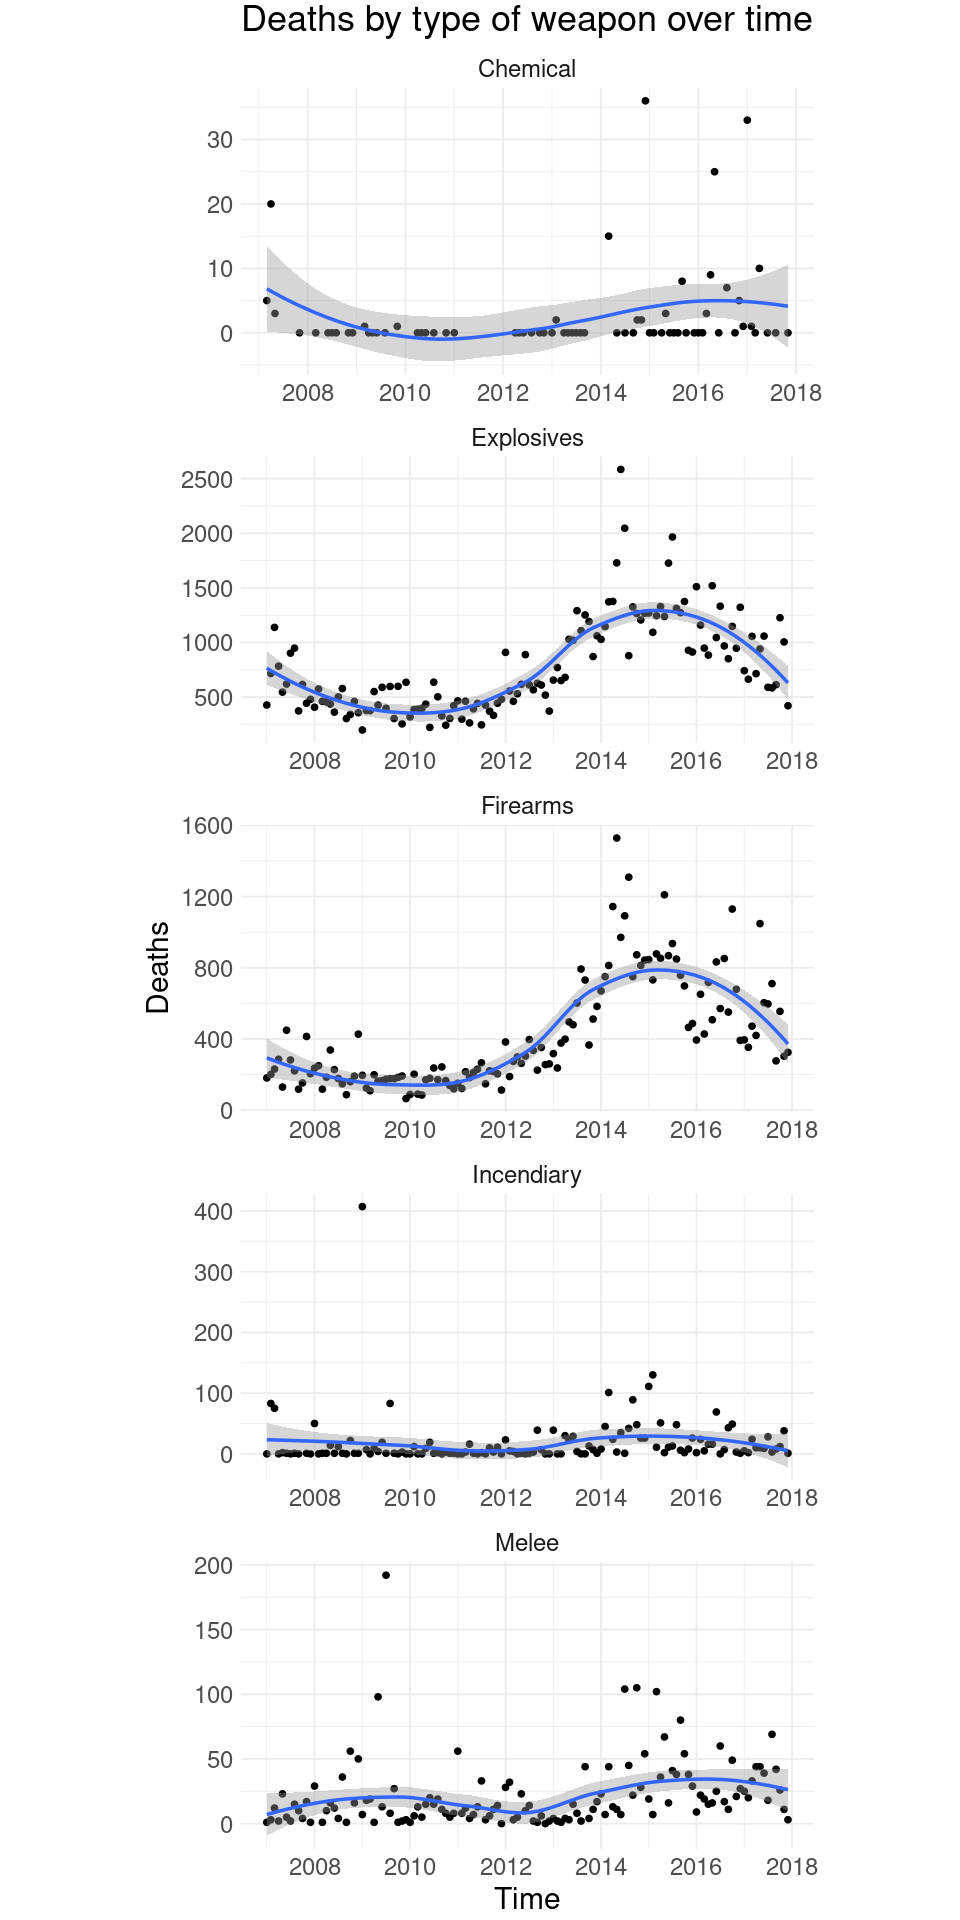

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 16)

nkill_by_weapon_monthly <- data %>%
    dplyr::select(year, month, nkill, weapon) %>% 
    dplyr::filter(weapon %in% by_weapon$weapon) %>%
    dplyr::group_by(year, month, weapon) %>%
    dplyr::summarise(nkill = sum(nkill), .groups = "drop") %>%
    dplyr::mutate(date = lubridate::make_date(year, month, 1)) %>%
    dplyr::select(-year, -month)

plot_weapon_ts <- ggplot(nkill_by_weapon_monthly, aes(x = date, y = nkill)) +
    ggtitle("Deaths by type of weapon over time") +
    ylab("Deaths") +
    xlab("Time") +
    geom_point() +
    geom_smooth(method = "loess", formula = " y ~ x") + 
    facet_wrap(~ weapon, ncol = 1, scales = "free") +
    theme_custom_ts()

plot_weapon_ts

ggsave("img/deaths_by_weapon_over_time.png", 
       plot = plot_weapon_ts, width = 12, height = 16, dpi = 75)

options(repr.plot.width = width, repr.plot.height = height)

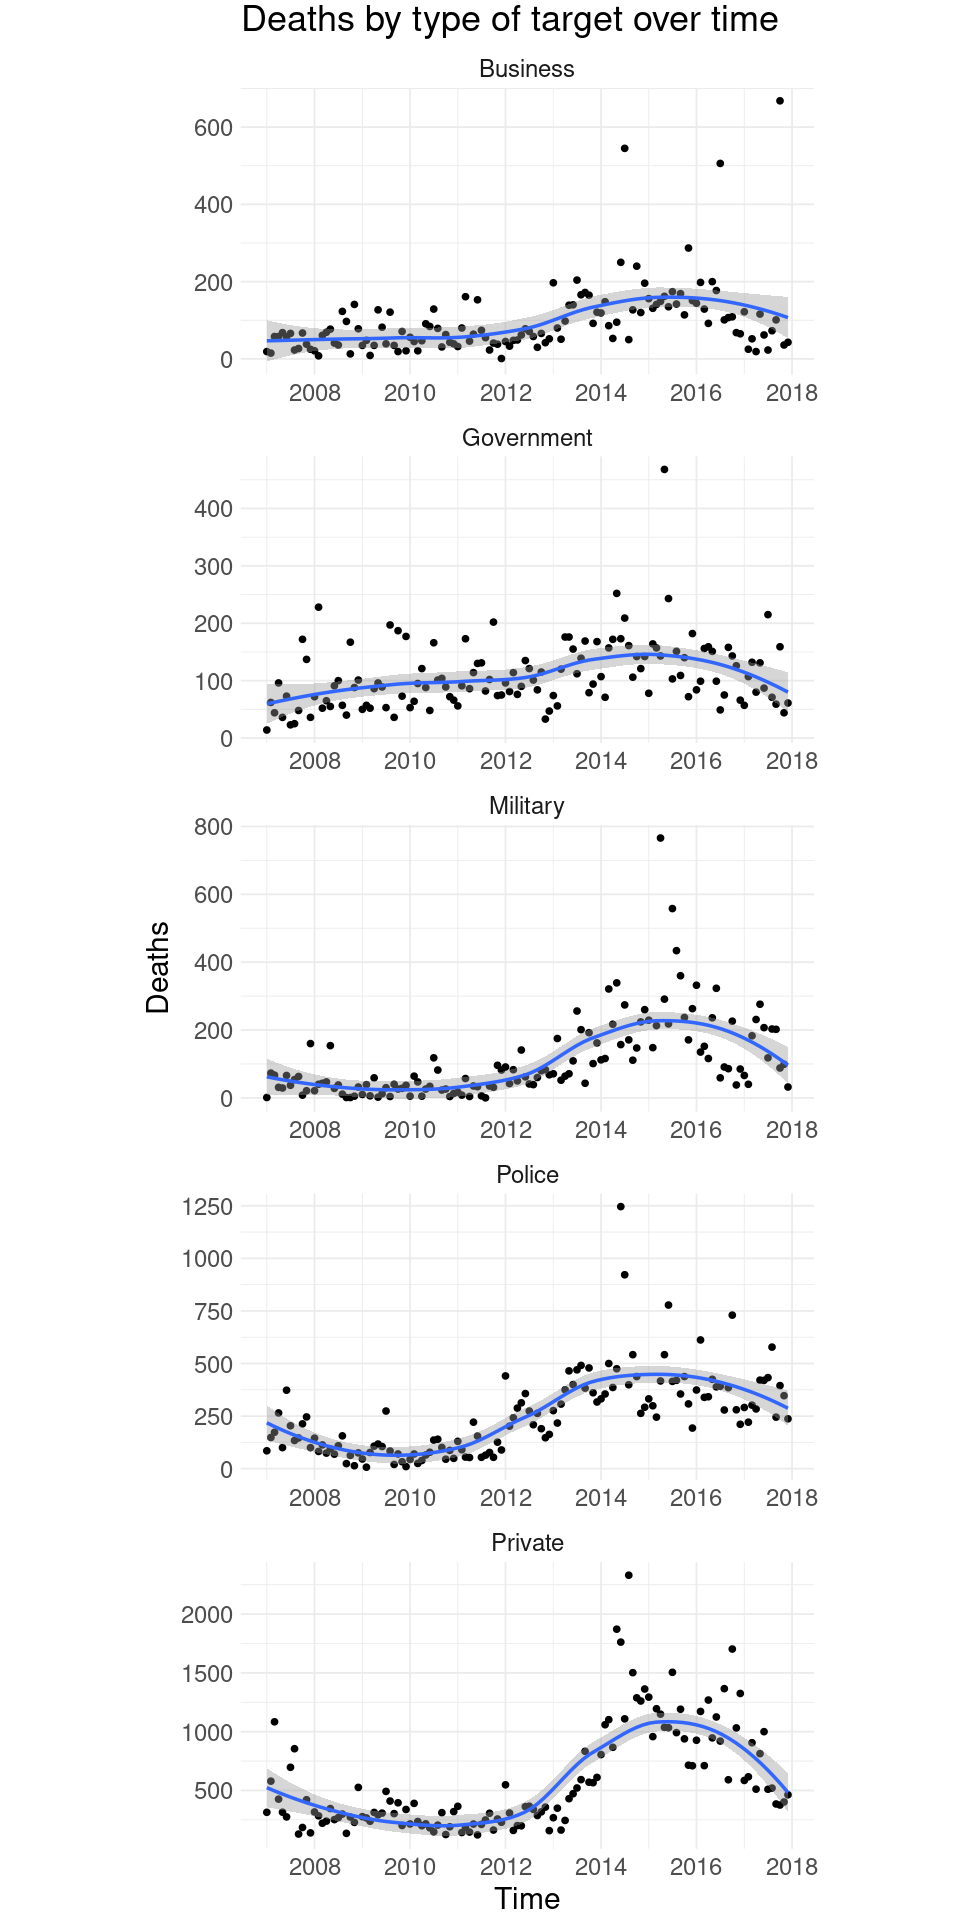

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 16)

nkill_by_target_monthly <- data %>%
    dplyr::select(year, month, nkill, target) %>% 
    dplyr::filter(target %in% by_target$target) %>%
    dplyr::group_by(year, month, target) %>%
    dplyr::summarise(nkill = sum(nkill), .groups = "drop") %>%
    dplyr::mutate(date = lubridate::make_date(year, month, 1)) %>%
    dplyr::select(-year, -month)

plot_target_ts <- ggplot(nkill_by_target_monthly, aes(x=date, y=nkill)) +
    ggtitle("Deaths by type of target over time") +
    ylab("Deaths") +
    xlab("Time") +
    geom_point() +
    geom_smooth(method = "loess", formula = " y ~ x") + 
    facet_wrap(~ target, ncol = 1, scales = "free") +
    theme_custom_ts()

plot_target_ts

ggsave("img/deaths_by_target_over_time.png", 
       plot = plot_target_ts, width = 12, height = 16, dpi = 75)

options(repr.plot.width = width, repr.plot.height = height)

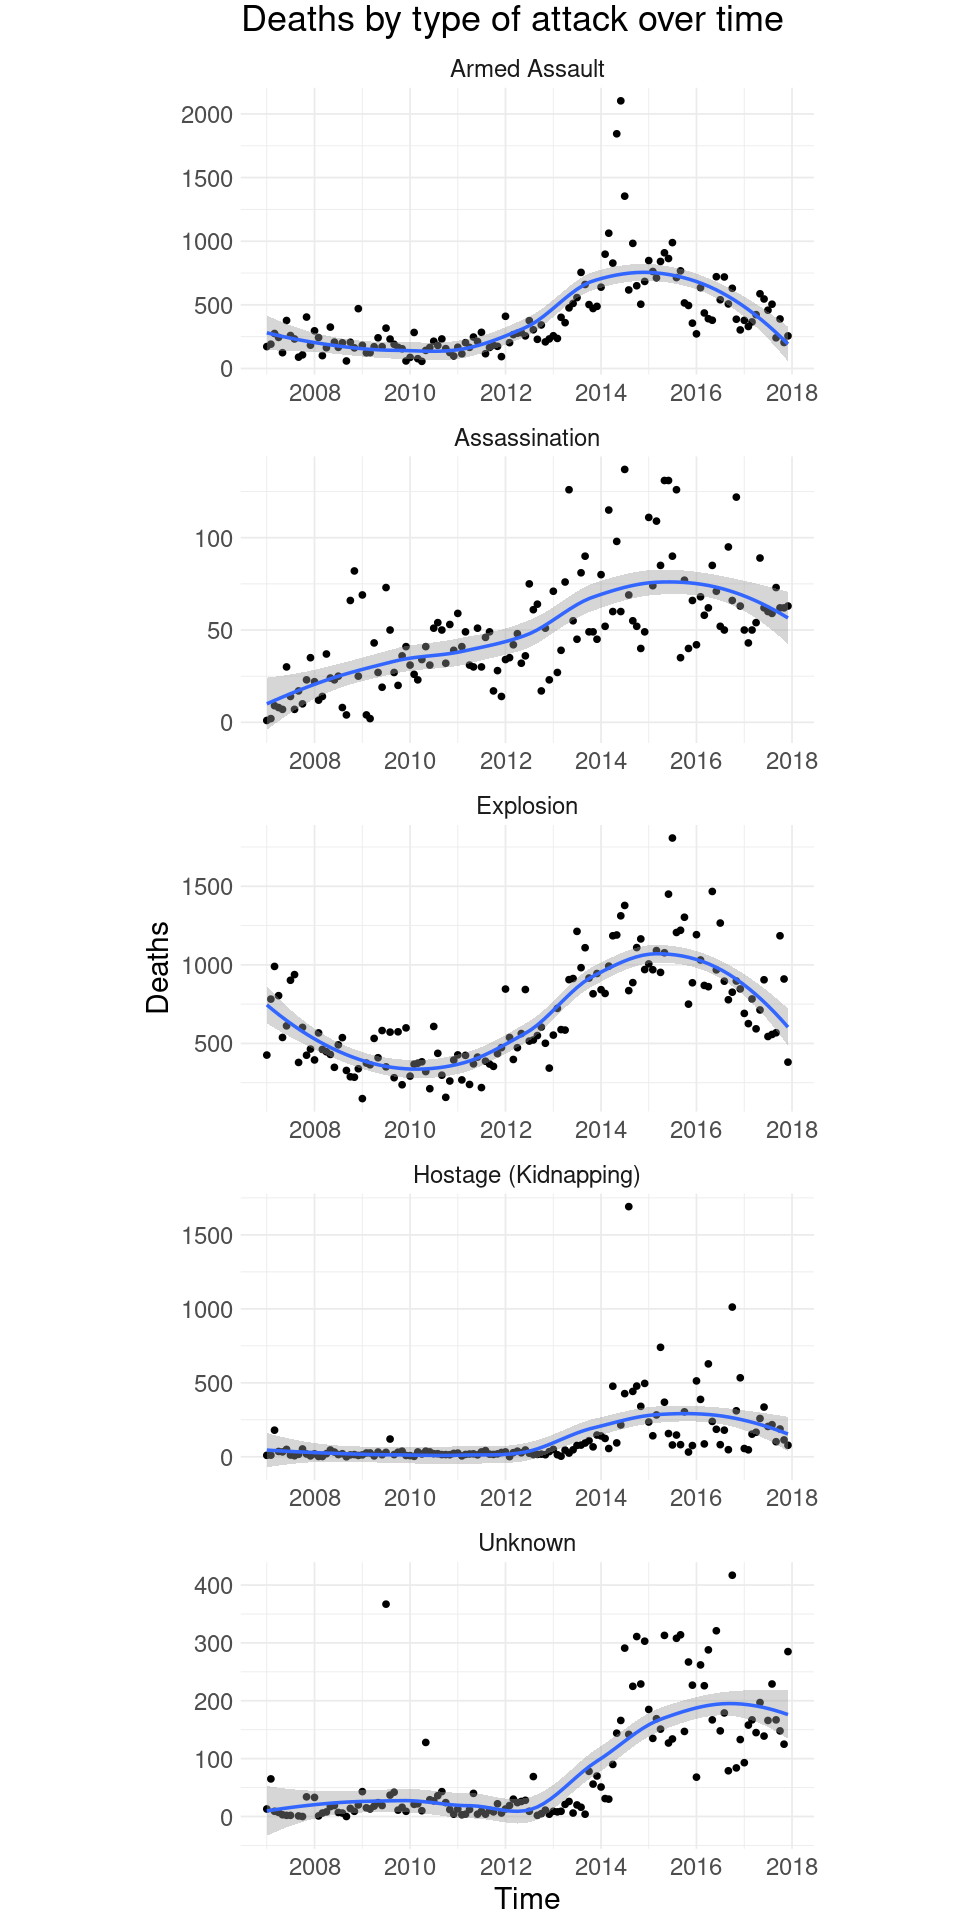

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 16)

nkill_by_attack_monthly <- data %>%
    dplyr::select(year, month, nkill, attack) %>% 
    dplyr::filter(attack %in% by_attack$attack) %>%
    dplyr::group_by(year, month, attack) %>%
    dplyr::summarise(nkill = sum(nkill), .groups = "drop") %>%
    dplyr::mutate(date = lubridate::make_date(year, month, 1)) %>%
    dplyr::select(-year, -month)

plot_attack_ts <- ggplot(nkill_by_attack_monthly, aes(x=date, y=nkill)) +
    ggtitle("Deaths by type of attack over time") +
    ylab("Deaths") +
    xlab("Time") +
    geom_point() +
    geom_smooth(method = "loess", formula = " y ~ x") + 
    facet_wrap(~ attack, ncol = 1, scales = "free") +
    theme_custom_ts()

plot_attack_ts

ggsave("img/deaths_by_attack_over_time.png", 
       plot = plot_attack_ts, width = 12, height = 16, dpi = 75)

options(repr.plot.width = width, repr.plot.height = height)

### Histograms

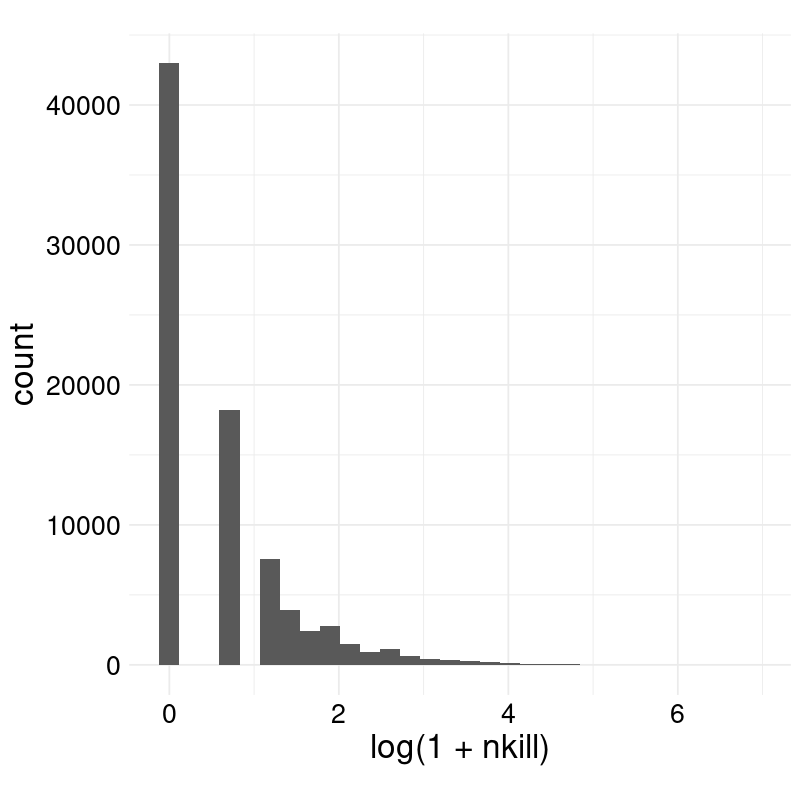

In [ ]:
ggplot(data = data, aes(x=log(1 + nkill))) +
    geom_histogram(bins = 30) +
    theme_custom()

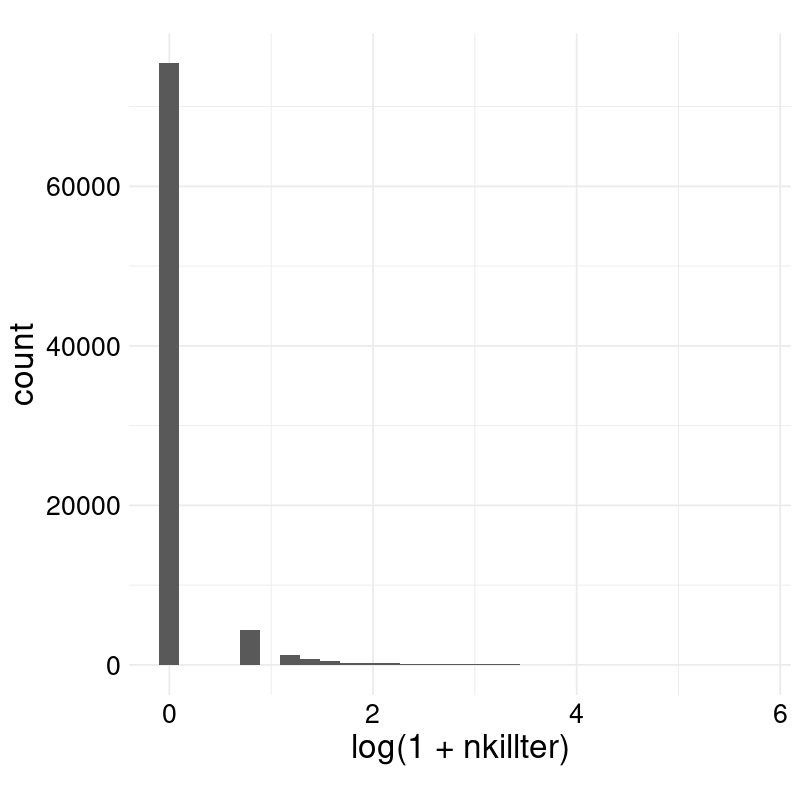

In [ ]:
ggplot(data = data, aes(x = log(1 + nkillter))) +
    geom_histogram(bins = 30) +
    theme_custom()

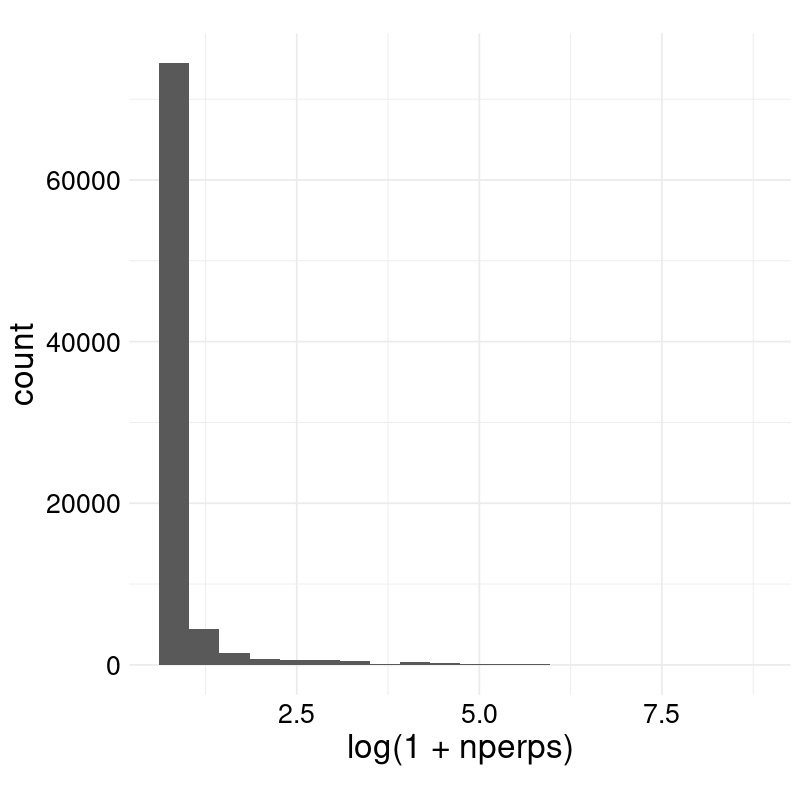

In [ ]:
ggplot(data = data, aes(x = log(1 + nperps))) +
    geom_histogram(bins = 20) +
    theme_custom()

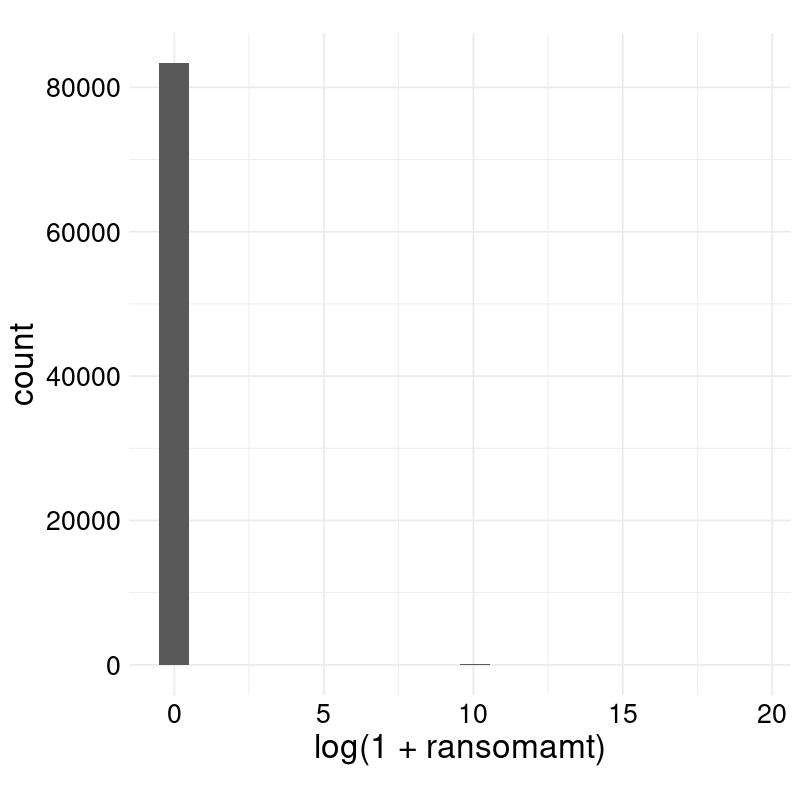

In [ ]:
ggplot(data = data, aes(x=log(1 + ransomamt))) +
    geom_histogram(bins=20) +
    theme_custom()

### Correlation

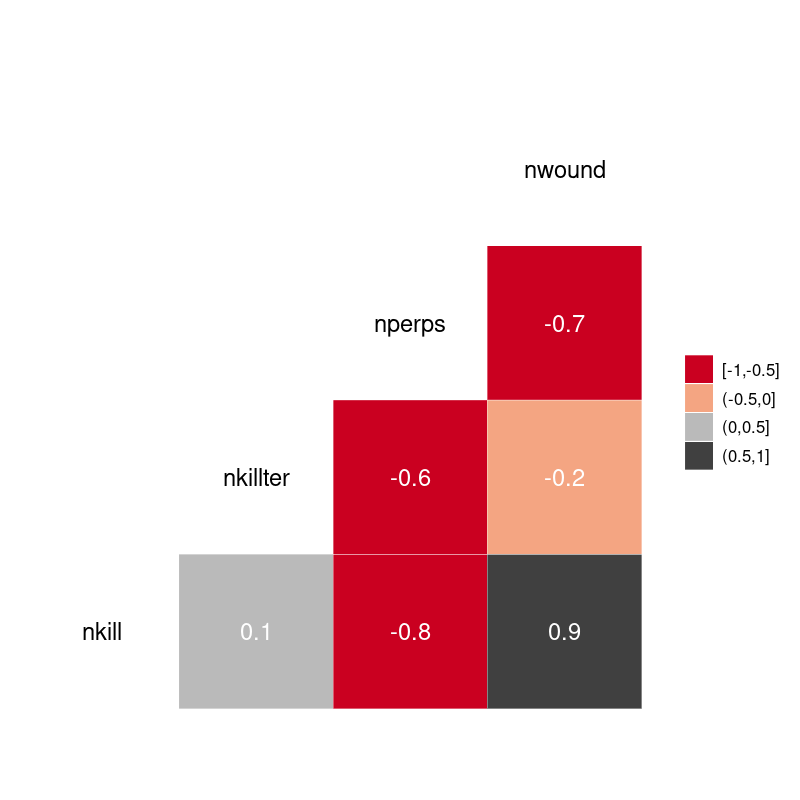

In [ ]:
C <- data %>%
    dplyr::select(nkill, nkillter, nperps, nwound) %>%
    dplyr::filter(complete.cases(.)) %>% 
    cor(.)

ggcorr(C, nbreaks = 4, label = TRUE, palette = "RdGy", 
       size = 5, label_color = "white", label_size = 5, 
       legend.size = 10)

## Binary columns

Count values in boolean columns.

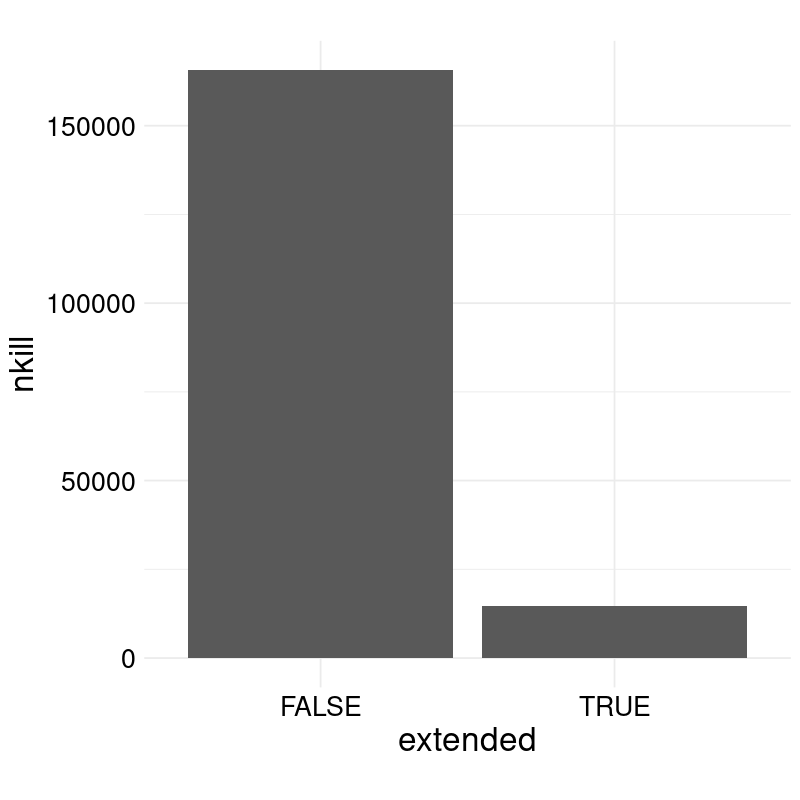

In [ ]:
by_extended <- data %>%
    dplyr::select(extended, nkill) %>%
    dplyr::group_by(extended) %>%
    dplyr::summarize(nkill = sum(nkill), .groups="drop")

ggplot(by_extended, aes(x = extended, y = nkill)) +
    geom_bar(stat = "identity") +
    theme_custom()

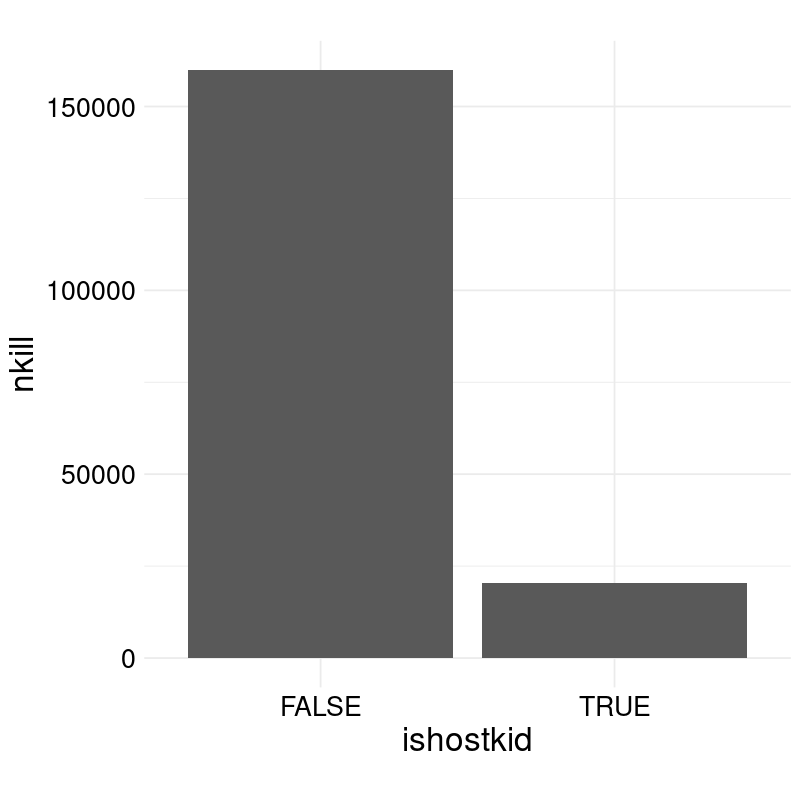

In [ ]:
by_ishostkid <- data %>%
    dplyr::select(ishostkid, nkill) %>%
    dplyr::group_by(ishostkid) %>%
    dplyr::summarize(nkill = sum(nkill), .groups = "drop")

ggplot(by_ishostkid, aes(x = ishostkid, y = nkill)) +
    geom_bar(stat = "identity") +
    theme_custom()

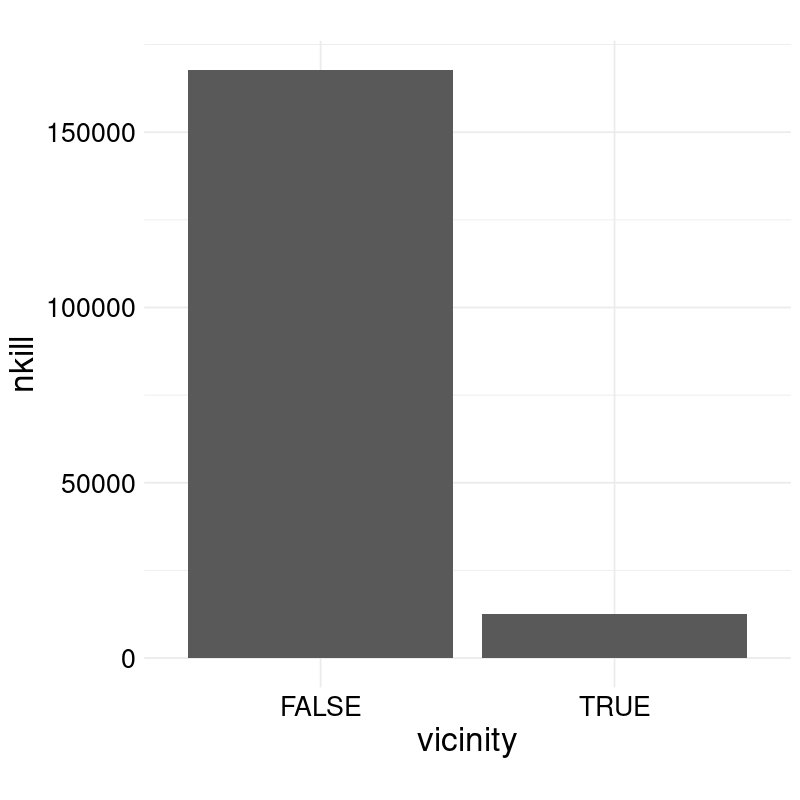

In [ ]:
by_vicinity <- data %>%
    dplyr::select(vicinity, nkill) %>%
    dplyr::group_by(vicinity) %>%
    dplyr::summarize(nkill = sum(nkill), .groups = "drop")

ggplot(by_vicinity, aes(x = vicinity, y = nkill)) +
    geom_bar(stat = "identity") +
    theme_custom()

## Geospatial variables

In [ ]:
most_active <- as.character(by_gname$gname)[1:5]

attacks <- data %>%
    dplyr::filter(gname %in% most_active) %>%
    dplyr::select(year, month, day, lat, long, gname, country, nkill) %>%
    dplyr::filter(!is.na(lat) & !is.na(long))

In [ ]:
location <- attacks %>%
    dplyr::group_by(gname, country) %>%
    dplyr::summarize(nkill = sum(nkill),
                     lat = mean(lat),                
                     long = mean(long), .groups = "drop") %>%
    dplyr::group_by(gname) %>%
    dplyr::arrange(dplyr::desc(nkill)) %>%
    dplyr::summarise(nkill = first(nkill),
                     country = first(country), 
                     lat = first(lat),
                     long = first(long),
                     .groups = "drop") %>%
    dplyr::mutate(full_gname = gname) %>%
    dplyr::mutate(full_gname = ifelse(full_gname == "ISIL", "Islamic State of Iraq and the Levant", as.character(full_gname))) %>%
    dplyr::mutate(full_gname = ifelse(full_gname == "TTP", "Tehrik-i-Taliban Pakistan", full_gname)) %>%
    dplyr::mutate(full_gname_ctry = paste(full_gname, ", ", country, sep = ""))

Regions defined for each Polygons



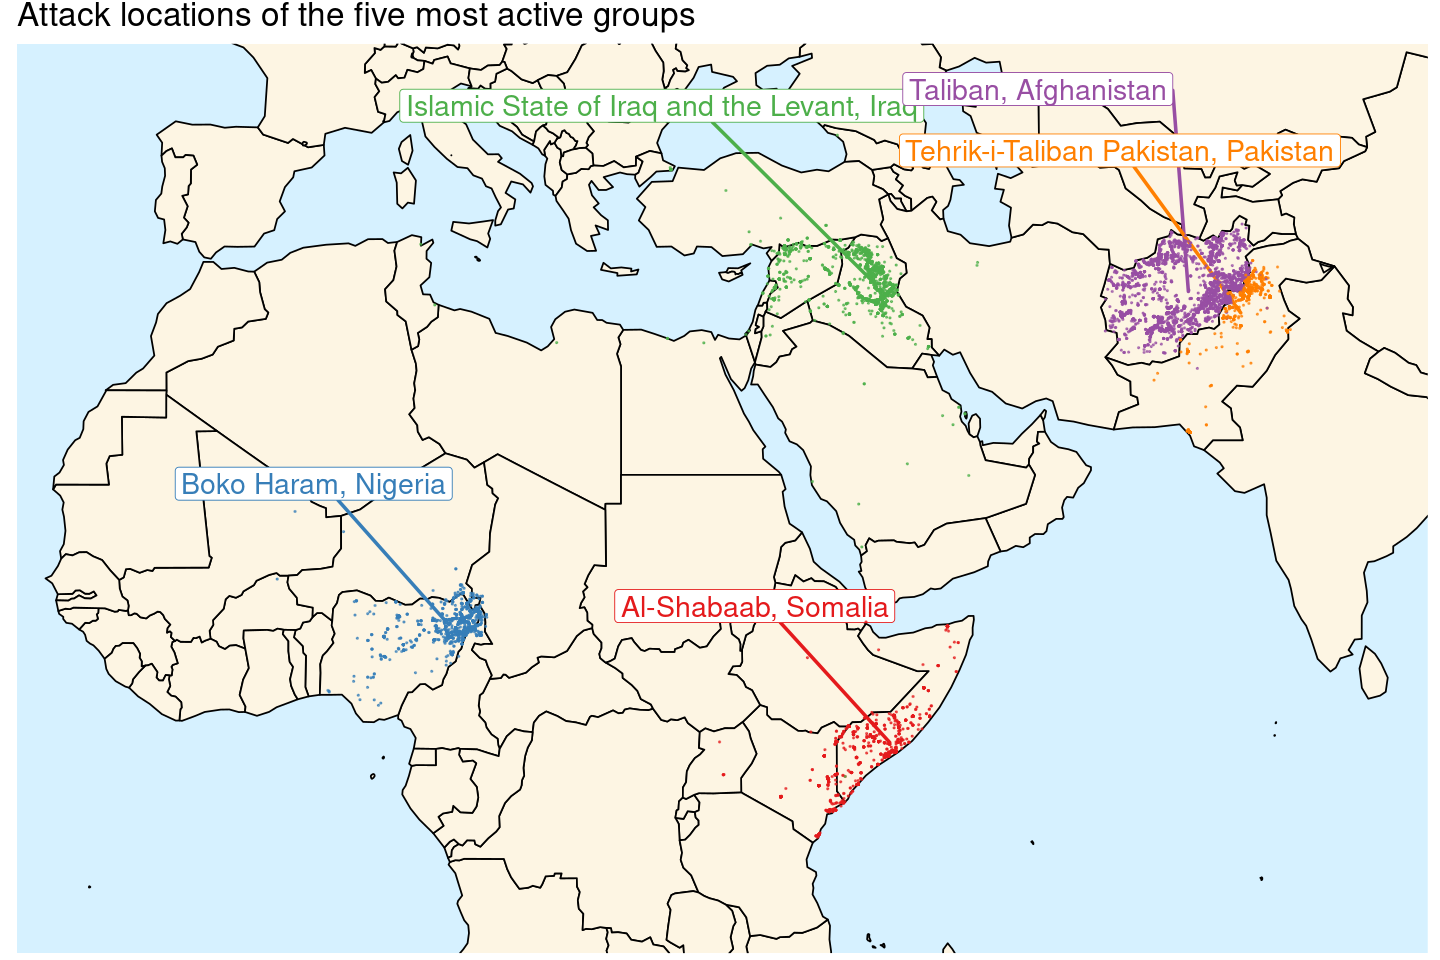

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 8)

world.map <- rworldmap::getMap()

plot_map_annotated <- ggplot() + 
    ggtitle("Attack locations of the five most active groups") +
    geom_polygon(data = world.map, aes(x = long, y = lat, group = group), fill = "#FDF5E3", color = "black") +
    geom_label_repel(data = location, aes(x = long, y = lat, label = full_gname_ctry, color = gname), 
                     size = 6, segment.size = 1, force = 30, nudge_y = 10, nudge_x = -10) + 
    geom_point(data = attacks, aes(x = long, y = lat, color = gname), size = 1/4, alpha = 2/3) +
    scale_color_manual(values = c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00')) +
    guides(color = FALSE) +
    coord_map(xlim = c(-15, 80), ylim = c(-10, 45)) +
    theme(panel.background = element_rect(fill = "#D6F1FF"),
          plot.margin = grid::unit(c(1/2, 0, 1/2, 0), "mm"),
          plot.title = element_text(size = 20),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),                 
          axis.title.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.text.x = element_blank(),          
          axis.title.y = element_blank(),
          axis.ticks.y = element_blank(),
          axis.text.y = element_blank(),
          legend.position = "bottom",          
          legend.title = element_text(size = 14),
          legend.text = element_text(size = 14))          

ggsave("img/group_attack_annotated_blue_sea.png", 
       plot = plot_map_annotated, width = 12, height = 8, dpi = 75)

plot_map_annotated

options(repr.plot.width = width, repr.plot.height = height)

In [ ]:
by_region_and_weapon <- data %>% 
    dplyr::filter(weapon != "Fake Weapons" & weapon != "Biological" & weapon != "Radiological") %>%
    dplyr::group_by(region, weapon) %>%
    dplyr::summarize(count = n(), .groups='drop') %>%
    dplyr::mutate(logcount = log(count, exp(1)),
                  label = ifelse(count > 1000, paste(round(count / 1000, 2), "K", sep = ""), count))

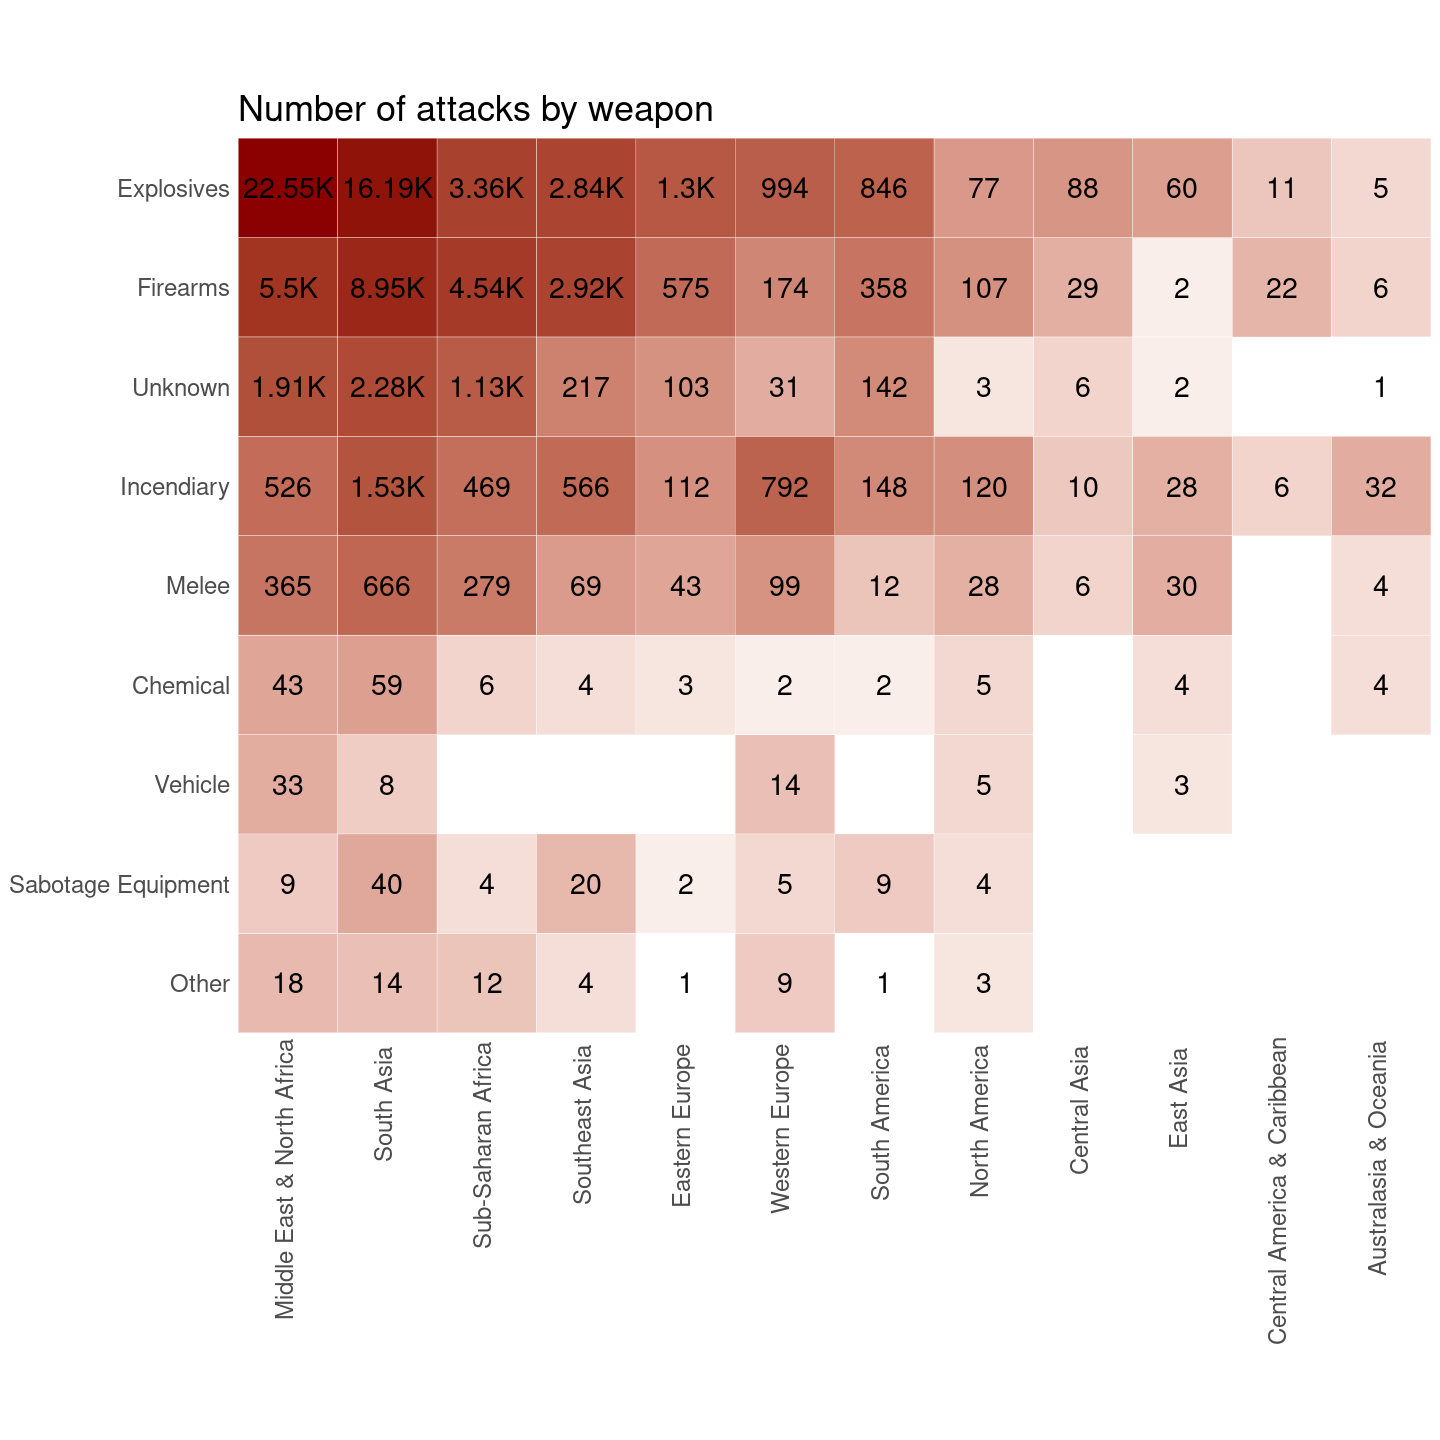

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 12)

plot_weapon_tile <- ggplot(data=by_region_and_weapon, aes(x = reorder(region, -count), 
                                                          y = reorder(weapon, count), 
                                                          fill=logcount, 
                                                          label=label)) +
    ggtitle("Number of attacks by weapon") +
    coord_fixed(1) + 
    geom_tile(color = "white", size = 0.1) +
    geom_text(size = 6) +
    scale_y_discrete(expand = c(0,0)) +
    scale_x_discrete(expand = c(0,0)) + 
    scale_fill_continuous(low = "white", high = "darkred", na.value = "black") + 
    guides(fill = FALSE) +
    theme_custom_tiles()

plot_weapon_tile

ggsave("img/attacks_by_weapon.png", 
       plot = plot_weapon_tile, width = 12, height = 12, dpi = 75)

options(repr.plot.width = width, repr.plot.height = height)

# Fancy plot for readme

In [ ]:
date <- seq.Date(as.Date('2007-01-01'), 
                 as.Date('2017-12-31'), 
                 by = 'month')

date <- dplyr::as_tibble(date) %>% 
        dplyr::rename(date = value)

most_active <- as.character(by_gname$gname)[1:5]

groups <- dplyr::as_tibble(most_active) %>% 
          dplyr::rename(gname = value)

date <- tidyr::crossing(date, groups)

nkill_total <- data %>%
    dplyr::filter(gname %in% most_active) %>%
    dplyr::select(year, month, gname, nkill) %>%
    dplyr::mutate(date = lubridate::make_date(year, month, 1)) %>%
    dplyr::group_by(date) %>%
    dplyr::summarize(nkill.total = sum(nkill), .groups='drop') %>%
    dplyr::right_join(date, by="date")

# nkill_total %>% dplyr::filter(is.na(nkill.total))

nkill_group <- data %>%
    dplyr::filter(gname %in% most_active) %>%
    dplyr::select(year, month, gname, nkill) %>%
    dplyr::mutate(date = lubridate::make_date(year, month, 1)) %>%
    dplyr::group_by(date, gname) %>%
    dplyr::summarize(nkill.group = sum(nkill), .groups='drop')

# nkill_group %>% dplyr::filter(is.na(nkill.group))

nkill_over_time <- dplyr::left_join(x = nkill_total, 
                                    y = nkill_group, 
                                    by = c("date" = "date", "gname" = "gname")) %>%
                   dplyr::mutate(nkill.group = tidyr::replace_na(nkill.group, 0)) %>%
                   dplyr::mutate(pct = nkill.group / nkill.total * 10 ** 4,
                                 pct = as.integer(pct),
                                 pct = round(x = pct / 10 ** 2, digits = 2))

plot_fancy_ts <- ggplot(data=nkill_over_time, aes(x = date, 
                                      y = pct)) +
    ggtitle('Fatality distribution among the five most active groups') +
    geom_area(position = 'stack', aes(fill = gname)) +
    geom_line(aes(group = gname), position = "stack", size = 1/10, alpha = 1/2) +
    ylab('Deaths (%)') +
    ylim(c(0, 100)) +
    labs(fill = 'Group') +
    scale_fill_brewer(palette = "Dark2") +
    guides(color = FALSE) +
    theme_minimal() +
    theme(plot.margin = grid::unit(c(1/2, 0, 1/2, 0), "mm"),
          plot.title = element_text(size = 8),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),          
          aspect.ratio = 1/2.75,
          axis.title.x = element_blank(),
          axis.title = element_text(size = 6),
          axis.text = element_text(size = 6),
          legend.position = "bottom",          
          legend.title = element_text(size = 6),
          legend.text = element_text(size = 6),
          legend.key.size = unit(1/3,"line"))

ggsave("img/top_five_groups_percent_ts.png", 
       plot = plot_fancy_ts, width = 4, height = 2, dpi = 150)

options(repr.plot.width = width, repr.plot.height = height)

In [ ]:
# options(repr.plot.width = 12, repr.plot.height = 12)
# p <- p + 
#     theme(plot.margin = grid::unit(c(1/2,0,1/2,0), "mm"),
#           plot.title = element_text(size=20),
#           legend.position="bottom",       
#           axis.title = element_text(size = 14),          
#           axis.text = element_text(size = 14),          
#           legend.title = element_text(size = 14),
#           legend.text = element_text(size = 14),
#           legend.key.size = unit(1/3,"line"))

# p

# options(repr.plot.width = width, repr.plot.height = height)